In [3]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import logging

logging.disable(logging.WARNING)
warnings.filterwarnings("ignore")

In [4]:
class SimilarityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe.dropna() 
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        score = self.data.iloc[idx][0]
        sentence1 = self.data.iloc[idx][1]
        sentence2 = self.data.iloc[idx][2]

        inputs = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'score': torch.tensor(score, dtype=torch.float)
        }


class BertSimilarityModel(nn.Module):
    def __init__(self, bert_model_name):
        super(BertSimilarityModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        similarity_score = self.linear(pooled_output)
        return similarity_score.squeeze(1)

train_data = pd.read_csv('Data/train.csv', sep='\t')
validation_data = pd.read_csv('Data/dev.csv', sep='\t')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = SimilarityDataset(train_data, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = SimilarityDataset(validation_data, tokenizer, max_length=128)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

model = BertSimilarityModel('bert-base-uncased')

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=3e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_losses = [] 
validation_losses = []  

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['score'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['score'].to(device)

            outputs = model(input_ids, attention_mask)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()

    validation_losses.append(total_val_loss / len(validation_loader))

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {validation_losses[-1]}")



Epoch 1/10: 100%|██████████| 357/357 [18:54<00:00,  3.18s/it]


Epoch 1/10, Training Loss: 0.9842740468033889, Validation Loss: 0.5808929476239111


Epoch 2/10: 100%|██████████| 357/357 [18:09<00:00,  3.05s/it]


Epoch 2/10, Training Loss: 0.3941861468495107, Validation Loss: 0.6544419710078965


Epoch 3/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 3/10, Training Loss: 0.23090208919734515, Validation Loss: 0.5986251360129403


Epoch 4/10: 100%|██████████| 357/357 [17:44<00:00,  2.98s/it]


Epoch 4/10, Training Loss: 0.16176294992450907, Validation Loss: 0.547596998796191


Epoch 5/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 5/10, Training Loss: 0.11960359654423236, Validation Loss: 0.5391427112905227


Epoch 6/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 6/10, Training Loss: 0.08685108365005806, Validation Loss: 0.52721991835405


Epoch 7/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 7/10, Training Loss: 0.07117463495185812, Validation Loss: 0.6152850327932317


Epoch 8/10: 100%|██████████| 357/357 [17:42<00:00,  2.98s/it]


Epoch 8/10, Training Loss: 0.06732064673640564, Validation Loss: 0.5426283604262964


Epoch 9/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 9/10, Training Loss: 0.057975477716397675, Validation Loss: 0.5589669915726003


Epoch 10/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 10/10, Training Loss: 0.058895413088155726, Validation Loss: 0.5524155271604009


In [5]:
model.eval()
predicted_scores = []
true_scores = []

with torch.no_grad():
    for batch in tqdm(validation_loader, desc='Validation'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['score'].numpy() 

        outputs = model(input_ids, attention_mask)
        predicted_scores.extend(outputs.cpu().numpy())
        true_scores.extend(targets)

pearson_corr = np.corrcoef(predicted_scores, true_scores)[0, 1]

print("Pearson correlation coefficient:", pearson_corr)

Validation: 100%|██████████| 92/92 [01:26<00:00,  1.06it/s]

Pearson correlation coefficient: 0.8700755408169226


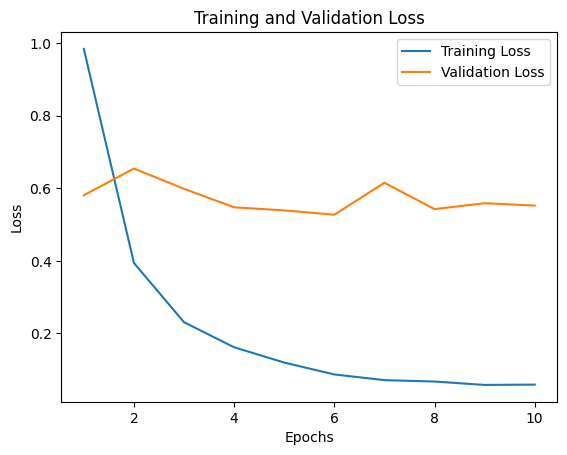

In [6]:
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

with open('bert_similarity_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [2]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [23]:
import pandas as pd
from scipy.stats import pearsonr
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
import math

In [31]:
class CustomDataset(Dataset):
    def __init__(self, file_path, scaler=None):
        self.data = pd.read_csv(file_path, sep='\t').dropna()
        self.scaler = scaler

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        score = item[0]
        sentence1 = str(item[1])
        sentence2 = str(item[2])
        if self.scaler:
            score = self.scaler.transform([[score]])[0][0]
        return sentence1, sentence2, score

def map_cos_to_zero_one(x):
    mapped_value = (x + 1) / 2
    return mapped_value

scaler = MinMaxScaler(feature_range=(0, 1)) 
validation_data = CustomDataset('Data/dev.csv', scaler=scaler)

scores = validation_data.data['score'].values.reshape(-1, 1)
scaler.fit(scores)

model = SentenceTransformer("all-MiniLM-L6-v2")

cos_similarities = []
labels = []

for sentence1, sentence2, score in validation_data:
    embedding1 = model.encode(sentence1, convert_to_tensor=True)
    embedding2 = model.encode(sentence2, convert_to_tensor=True)

    cosine_similarity = util.pytorch_cos_sim(embedding1, embedding2).item()
    mapped_value = map_cos_to_zero_one(cosine_similarity)

    cos_similarities.append(mapped_value)
    labels.append(score)

pearsons_corr, _ = pearsonr(labels, cos_similarities)

print("Pearson's correlation coefficient on validation set:", pearsons_corr)


Pearson's correlation coefficient on validation set: 0.8631423871595579


In [ ]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [5]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample, evaluation
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import os
import csv
import warnings
import logging
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt

logging.disable(logging.WARNING)
warnings.filterwarnings("ignore")

In [8]:
model_name = "nli-distilroberta-base-v2"
train_batch_size = 16

model = SentenceTransformer(model_name)

def my_loss(output, label):
    loss = losses.CosineSimilarityLoss(model=model)(output, label)
    return loss


df = pd.read_csv("train.csv", delimiter='\t', encoding="utf-8").dropna()

df['score'] = df['score'].astype(float) / 5.0
trainsentences1 = []
trainsentences2 = []
trainscores = []
train_samples = []
for index, row in df.iterrows():
    inp_example = InputExample(texts=[row["sentence1"], row["sentence2"]], label=row["score"])
    train_samples.append(inp_example)
    score = float(row["score"]) / 5.0
    trainsentences1.append(row["sentence1"])
    trainsentences2.append(row["sentence2"])
    trainscores.append(score)

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)


epochs = 2
df = pd.read_csv("dev.csv", delimiter="\t", encoding="utf-8").dropna()

devsentences1 = []
devsentences2 = []
devscores = []

for index, row in df.iterrows():
    score = float(row["score"]) / 5.0
    devsentences1.append(row["setence1"])
    devsentences2.append(row["sentence2"])
    devscores.append(score)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs = epoch+1)
    trainembeddings1 = model.encode(trainsentences1, convert_to_tensor=True)
    trainembeddings2 = model.encode(trainsentences2, convert_to_tensor=True)
    train_cosine_scores = util.cos_sim(trainembeddings1, trainembeddings2)
    train_predictions = []
    for i in range(len(train_cosine_scores)):
        train_predictions.append(train_cosine_scores[i][i])
    mse_loss = mean_squared_error(train_predictions, trainscores)
    train_losses.append(mse_loss)
    devembeddings1 = model.encode(devsentences1, convert_to_tensor=True)
    devembeddings2 = model.encode(devsentences2, convert_to_tensor=True)
    dev_cosine_scores = util.cos_sim(devembeddings1, devembeddings2)
    dev_predictions = []
    for i in range(len(dev_cosine_scores)):
        dev_predictions.append(dev_cosine_scores[i][i])
    mse_loss = mean_squared_error(dev_predictions, devscores)   #cosine similarity loss has been implemented here (where loss_fct = MSE LOSS)
    val_losses.append(mse_loss*10)
    pearson_corr, _ = pearsonr(dev_predictions, devscores)
    print(f"Epoch : {epoch} Train loss : {train_losses[-1]} Val loss : {val_losses[-1]} Pearson Correlation : {pearson_corr}")


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch : 0 Train loss : 0.3152616332640056 Val loss : 0.26872962171040315 Pearson Correlation : 0.8705970383070621


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch : 1 Train loss : 0.3000498040994424 Val loss : 0.23635153107614582 Pearson Correlation : 0.8806409824206274


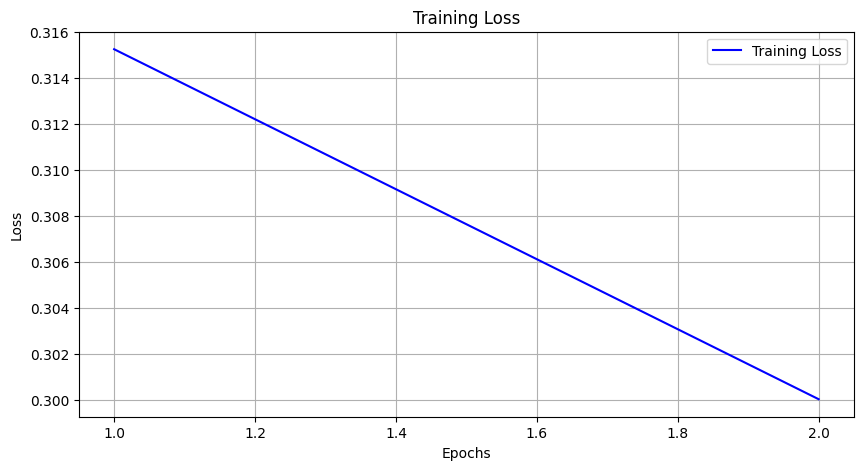

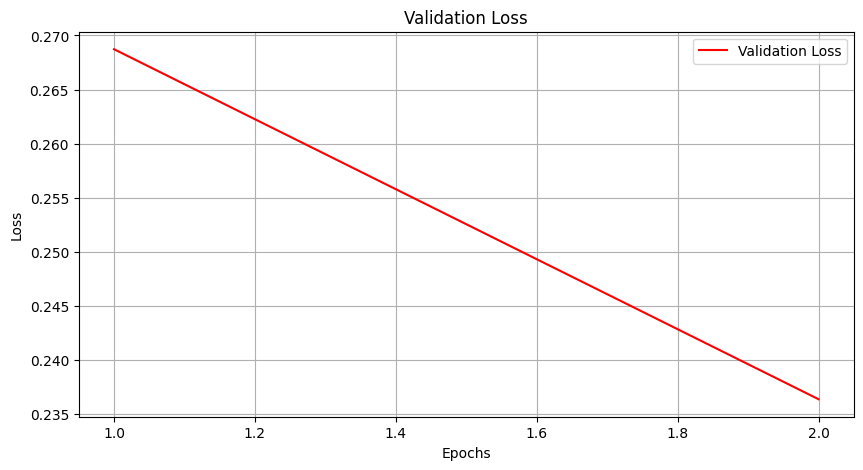

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

with open('model_setup1C_new.pkl', 'wb') as f:
    pickle.dump(model, f)

<h1><b>2A SETUP


In [1]:
def import_tensorflow():
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf
tf = import_tensorflow()    

In [2]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 400)
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

import tensorflow_text as tf_text

In [44]:
class ShapeChecker():
  def __init__(self):
    self.shapes = {}
  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return
    parsed = einops.parse_shape(tensor, names)
    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      if (broadcast and new_dim == 1):
        continue
      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

<h1><b> The data

In [6]:
from datasets import load_dataset

train_dataset  =   load_dataset("wmt16","de-en", split="train[:400000]")
val_dataset    =   load_dataset("wmt16","de-en", split="validation")
test_dataset   =   load_dataset("wmt16","de-en", split="test")

In [8]:
def extract_sentences(datadict):
    de_sentences=[]
    en_sentences=[]
    for de_en in datadict["translation"]:
        de_sentences.append(de_en['de'].lower())
        en_sentences.append(de_en['en'].lower())
    return np.array(de_sentences), np.array(en_sentences)

In [11]:
train_de , train_en  =  extract_sentences(train_dataset)
val_de   , val_en    =  extract_sentences(val_dataset)
test_de  , test_en   =  extract_sentences(test_dataset)

In [48]:
BUFFER_SIZE = len(train_de)
BATCH_SIZE = 128
is_train = np.random.uniform(size=(len(train_de),)) < 0.8
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_de[is_train],train_en[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_de[~is_train],train_en[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

normalisation and standardisation:

In [49]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

Text Vectorization

In [50]:
max_vocab_size = 75000
de_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)
de_text_processor.adapt(train_raw.map(lambda context, target: context))

In [51]:
en_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)
en_text_processor.adapt(train_raw.map(lambda context, target: target))
#target_text_processor.get_vocabulary()[:10]

### Process the dataset



In [52]:
def process_text(context, target):
  context = de_text_processor(context).to_tensor()
  target = en_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

<h3> <b>Encoder Decoder

In [53]:
UNITS = 512

In [54]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [55]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  5  47   7 486 302 170 261   2  18 104]

[  4  67   7   2 515  16  15  13   3   7]
[ 67   7   2 515  16  15  13   3   7 174]


In [56]:
encoder = Encoder(de_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

<h3><b> Attention Layer

In [57]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [58]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(en_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)


In [59]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.0000001 ,
       0.9999999 , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 0.9999998 , 1.        , 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 0.9999998 , 1.        ,
       0.9999998 , 1.        , 1.        , 0.99999994, 1.0000001 ,
       0.9999999 , 1.        , 0.99999994, 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994], dtype=float32)

In [60]:
attention_weights = attention_layer.last_attention_weights
#mask=(ex_context_tok != 0).numpy()

# plt.subplot(1, 2, 1)
# plt.pcolormesh(mask*attention_weights[:, 0, :])
# plt.title('Attention weights')

# plt.subplot(1, 2, 2)
# plt.pcolormesh(mask)
# plt.title('Mask');


<h3><b> Decoder

In [61]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

In [62]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [63]:
decoder = Decoder(en_text_processor, UNITS)

In [64]:
logits = decoder(ex_context, ex_tar_in)

In [65]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [66]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [67]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [68]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
#result[:3].numpy()

In [69]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [70]:
model = Translator(UNITS, de_text_processor, en_text_processor)
logits = model((ex_context_tok, ex_tar_in))

<b><h1> Training

In [71]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [72]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [73]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [74]:
# vocab_size = 1.0 * en_text_processor.vocabulary_size()

# {"expected_loss": tf.math.log(vocab_size).numpy(),
#  "expected_acc": 1/vocab_size}

That should roughly match the values returned by running a few steps of evaluation:

In [75]:
#model.evaluate(val_ds, steps=50, return_dict=True)

In [76]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 256,
    validation_data=val_ds,
    validation_steps = 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
256/256 [==============================] - 55s 185ms/step - loss: 5.3338 - masked_acc: 0.2011 - masked_loss: 5.3338 - val_loss: 4.6722 - val_masked_acc: 0.2522 - val_masked_loss: 4.6722
Epoch 2/100
256/256 [==============================] - 44s 172ms/step - loss: 4.4971 - masked_acc: 0.2664 - masked_loss: 4.4971 - val_loss: 4.3853 - val_masked_acc: 0.2759 - val_masked_loss: 4.3853
Epoch 3/100
256/256 [==============================] - 44s 173ms/step - loss: 4.2972 - masked_acc: 0.2826 - masked_loss: 4.2972 - val_loss: 4.2259 - val_masked_acc: 0.2882 - val_masked_loss: 4.2259
Epoch 4/100
256/256 [==============================] - 44s 173ms/step - loss: 4.1780 - masked_acc: 0.2922 - masked_loss: 4.1780 - val_loss: 4.1265 - val_masked_acc: 0.2953 - val_masked_loss: 4.1265
Epoch 5/100
256/256 [==============================] - 44s 172ms/step - loss: 4.0936 - masked_acc: 0.2996 - masked_loss: 4.0936 - val_loss: 4.0532 - val_masked_acc: 0.3051 - val_masked_loss: 4.0532
Epoch 6/10

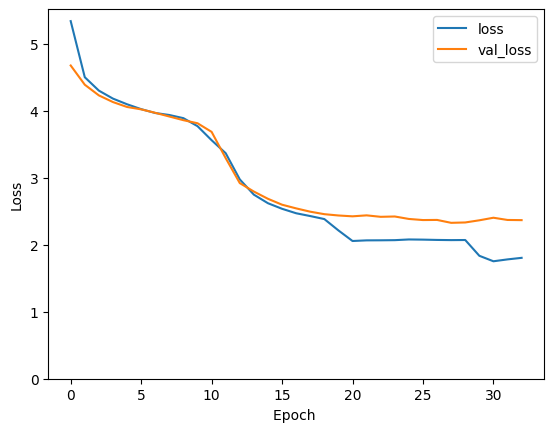

In [77]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch ')
plt.ylabel('Loss')
plt.legend()

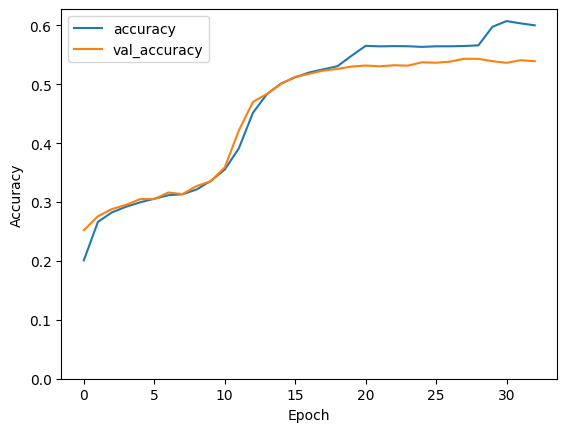

In [78]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [79]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [96]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [97]:
export = Export(model)

In [106]:
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [4]:
model = tf.saved_model.load('translator')

In [3]:
def translation_results(test_dataset):
  preds=[]
  for t in tqdm(test_dataset):
    preds.append(model.translate([t])[0].numpy().decode())
  return preds

In [9]:
import pickle
test_de_translations=translation_results(test_de)
x=pd.DataFrame({"actual":test_en, "predicted": test_de_translations})
x

100%|██████████| 2999/2999 [11:16<00:00,  4.43it/s]


,actual,predicted
0,obama receives netanyahu,noiseinduced deafness
1,the relationship between obama and netanyahu is not exactly friendly.,the relationship between the danube river and the netanyahu is not exactly friendly .
2,the two wanted to talk about the implementation of the international agreement and about teheran's destabilising activities in the middle east.,the two were intended to speak about the implementation of the international agreement and on the ad hoc hoc action in the middle east .
3,the meeting was also planned to cover the conflict with the palestinians and the disputed two state solution.,"however , when it comes to the dispute with the palestinians and the us we are talking about the twostate solution ."
4,relations between obama and netanyahu have been strained for years.,the relationship between the danube river and the netanyahu has been of great interest for years .
...,...,...
2994,mercury is released into the environment primarily through the burning of coal.,"mercury , mainly environmental audits , are the environment ."
2995,"german coal plants, according to written information from the german ministry of the environment to green bundestag member annalena baerbock, discharge more than six tonnes of mercury per year, two thirds of the total amount emitted in germany.",the german coal plants are being quoted according to a written document issued by the caa .
2996,"the concentration of mercury in fish, for example in the elbe, rhine and danube, is ""extensively exceeded on a long-term basis,"" the ""spiegel"" newspaper quoted from the paper in march.","the concentration of mercury in fish in fish is the elbe , the replacement of the biomass and the danube river , has been quoted in the wake of the paper ."
2997,"in the past year, europe-wide alerts on mercury in fish rated among the most frequently reported health risks in the eu warning system rasff.","last year , the total number of redundancies were already covered by the total of the health risks of the disease in jeopardy ."


In [10]:
val_de_translations=translation_results(val_de)
x=pd.DataFrame({"actual":val_en, "predicted": val_de_translations})
x

100%|██████████| 2169/2169 [07:57<00:00,  4.54it/s]


,actual,predicted
0,india and japan prime ministers meet in tokyo,the prime minister of india met in tokyo .
1,"india's new prime minister, narendra modi, is meeting his japanese counterpart, shinzo abe, in tokyo to discuss economic and security ties, on his first major foreign visit since winning may's election.","india has been razed to the ground , in its first important readings , since its election won in may , in may , in order to discuss economic and security relations with the japanese , in order to discuss economic and security relations ."
2,mr modi is on a five-day trip to japan to strengthen economic ties with the third largest economy in the world.,mr habib souaidia is right to strengthen the relationship with the third country in order to consolidate the economy s third largest country .
3,high on the agenda are plans for greater nuclear co-operation.,plans for a greater nuclear power are the top priority on the agenda .
4,india is also reportedly hoping for a deal on defence collaboration between the two nations.,reports that india are also united on with a treaty cooperation agreement between the two nations .
...,...,...
2164,the walkers started at 9.30 am.,the main salary of the midnight oil at . . . .
2165,"then it was the turn of the cyclists and runners, who began at 10 am.",the first cyclists and accidents have been taken at oclock .
2166,five minutes later the first mountain-bikers set off.,"five minutes later , the first week of distributing the first freight transport ."
2167,"bent hansen, chairman of the association 'cycling on the grosser feldberg' gave the starting orders and wished those taking part an enjoyable trip.","the jubilant militia camps , chairman of the association committee , were the main manufacturing lines , the main cerealgrowing areas , the main cerealgrowing areas , the main cerealgrowing areas ."


In [11]:
with open("translations_results.pkl","wb") as f:
    pickle.dump([val_de_translations,test_de_translations],f)

In [2]:
import pickle
with open("translations_results.pkl","rb") as f:
    val_de_translations,test_de_translations=pickle.load(f)

<h2><b>BLEU | METEOR | BERT Score

In [3]:
import evaluate
bleu=evaluate.load("bleu")
meteor=evaluate.load("meteor")
bertScore=evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /home/iiitd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/iiitd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iiitd/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
def evaluation(predictions,actual):
    for i in range(1,5):
        results = bleu.compute(predictions=predictions, references=actual,max_order=i)
        print(f"BLEU-{i} results: ",results)

    results=meteor.compute(predictions=predictions, references=actual)
    print("\nMeteor Results : ",results)
    results=bertScore.compute(predictions=predictions, references=actual, lang='en')
    print("\nBertScore: ",results)

In [12]:
print("\nValidation dataset Evaluation: ")
evaluation(val_de_translations,val_en)

print("\nTest dataset Evaluation: ")
evaluation(test_de_translations,test_en)

Validation dataset Evaluation: 
BLEU-1 results: 
 {'bleu': 0.37749906867006083, 'precisions': [0.37749906867006083], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}
BLEU-2 results: 
 {'bleu': 0.21457692073978532, 'precisions': [0.37749906867006083, 0.12196918809993283], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}
BLEU-3 results: 
 {'bleu': 0.1313923720037701, 'precisions': [0.37749906867006083, 0.12196918809993283, 0.04926567544218615], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}
BLEU-4 results: 
 {'bleu': 0.08351144009194787, 'precisions': [0.37749906867006083, 0.12196918809993283, 0.04926567544218615, 0.021442401931489493], 'brevity_penalty': 1.0, 'length_ratio': 1.0403720689877916, 'translation_length': 48318, 'reference_length': 46443}

Meteor Results : 
 {'meteor': 0.31274

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BertScore:  {'precision': [0.9122360944747925, 0.8384669423103333, 0.8622722625732422, 0.8967468738555908, 0.882927656173706, 0.8288441896438599, 0.8486132025718689, 0.8421233296394348, 0.8599801063537598, 0.8361684679985046, 0.8357506990432739, 0.8334370851516724, 0.8499454259872437, 0.8346530795097351, 0.9168421030044556, 0.8989938497543335, 0.8803643584251404, 0.8410918116569519, 0.8080213665962219, 0.8730837106704712, 0.9281264543533325, 0.8550471067428589, 0.848495602607727, 0.8589200973510742, 0.9029537439346313, 0.8420937061309814, 0.8960981369018555, 0.8534574508666992, 0.8796025514602661, 0.8660894632339478, 0.8314673900604248, 0.8806643486022949, 0.8692543506622314, 0.8573950529098511, 0.8886598348617554, 0.8714078068733215, 0.8550658226013184, 0.877668023109436, 0.8548003435134888, 0.818505048751831, 0.8922784328460693, 0.8714801669120789, 0.8926606178283691, 0.8911246657371521, 0.8487939834594727, 0.8769047856330872, 0.8592164516448975, 0.8379970788955688, 0.83363473415374

In [14]:
sentence=input("enter your sentence :")
results=translation_results([sentence])
print(results)

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

['the political meeting was right                                             ']


In [11]:
import pandas as pd
data=pd.read_csv("input.csv",encoding='unicode_escape')

german_sentences=data['de'].tolist()

results=translation_results(german_sentences)
data["en"]=results
display(data)

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


,de,en
0,wie hei§t du,in other words you
1,Mein Name ist Obama,my name is ramiro zapata
2,Das politische Treffen wurde richtig durchgefhrt,the political meeting was right


<h1><b> 2B SETUP

In [3]:
from datasets import load_dataset
val_dataset    =   load_dataset("wmt16","de-en", split="validation")
test_dataset   =   load_dataset("wmt16","de-en", split="test")

In [4]:
import numpy as np
from tqdm import tqdm
def extract_sentences(datadict):
    de_sentences=[]
    en_sentences=[]
    for de_en in datadict["translation"]:
        de_sentences.append(de_en['de'].lower())
        en_sentences.append(de_en['en'].lower())
    return np.array(de_sentences), np.array(en_sentences)

In [5]:
val_de   , val_en    =  extract_sentences(val_dataset)
test_de  , test_en   =  extract_sentences(test_dataset)

In [6]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
val_translations=[]
test_translations=[]

for sentence in tqdm(val_en):
    eng_sentence = sentence
    prefix = "translate English to German: "

    input_text = prefix + eng_sentence
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    german_translation = tokenizer.decode(output[0], skip_special_tokens=True)

    # print("English: ", eng_sentence)
    # print("german Translation: ", german_translation)
    val_translations.append(german_translation)


for sentence in tqdm(test_en):
    eng_sentence = sentence
    prefix = "translate English to German: "

    input_text = prefix + eng_sentence
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    german_translation = tokenizer.decode(output[0], skip_special_tokens=True)

    # print("English: ", eng_sentence)
    # print("german Translation: ", german_translation)
    test_translations.append(german_translation)


100%|██████████| 2999/2999 [39:30<00:00,  1.27it/s]  


In [12]:
import pickle
with open('translations.pkl','wb') as f:
    pickle.dump([val_translations,test_translations],f)

In [1]:
import pickle
with open('translations.pkl',"rb") as f:
    val_translations,test_translations=pickle.load(f)

In [2]:
import evaluate
bleu=evaluate.load("bleu")
meteor=evaluate.load("meteor")
bertScore=evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /home/iiitd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/iiitd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iiitd/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
def evaluationMetrics(reference, predictions):
    for i in range(1,5):
        print(f"BLEU-{i} evaluation:",bleu.compute(references=reference,predictions=predictions,max_order=i))

    print("\nMETEOR Score: ",meteor.compute(references=reference,predictions=predictions))

    print("\nBERTScore: ", bertScore.compute(predictions=reference,references=predictions,lang='en'))

In [7]:
print("Validation dataset zero-Shot evaluation : ")
evaluationMetrics(val_de,val_translations)
print("\nTest dataset zero-Shot evaluation : ")
evaluationMetrics(test_de,test_translations)

Validation dataset zero-Shot evaluation : 
BLEU-1 evaluation: {'bleu': 0.4757060634453219, 'precisions': [0.4757060634453219], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}
BLEU-2 evaluation: {'bleu': 0.30666572511914747, 'precisions': [0.4757060634453219, 0.19769322737182643], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}
BLEU-3 evaluation: {'bleu': 0.20943201112543214, 'precisions': [0.4757060634453219, 0.19769322737182643, 0.09767843912077057], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}
BLEU-4 evaluation: {'bleu': 0.14705278059281643, 'precisions': [0.4757060634453219, 0.19769322737182643, 0.09767843912077057, 0.05090539059646193], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}

METEOR Score:  {'meteor': 0.530

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore:  {'precision': [0.8894785046577454, 0.9076931476593018, 0.9242793917655945, 0.896828293800354, 0.8904922604560852, 0.9104254245758057, 0.9490283727645874, 0.9059965014457703, 0.9063154458999634, 0.9123014211654663, 0.8627183437347412, 0.9331455230712891, 0.8971627950668335, 0.9485757350921631, 0.882827639579773, 0.9121001958847046, 0.9253000617027283, 0.8663098812103271, 0.8813304901123047, 0.878788948059082, 0.874433696269989, 0.9072525501251221, 0.8928102254867554, 0.9062881469726562, 0.8859453797340393, 0.9064558148384094, 0.9366355538368225, 0.8936944603919983, 0.9012700319290161, 0.9004562497138977, 0.9217568635940552, 0.8901947736740112, 0.9160059094429016, 0.8807432055473328, 0.8830481767654419, 0.8726894855499268, 0.9376012086868286, 0.9044404625892639, 0.8604651093482971, 0.9350894689559937, 0.9031029939651489, 0.9162684679031372, 0.8877121210098267, 0.9583418965339661, 0.9037118554115295, 0.9257569313049316, 0.899071991443634, 0.8844363689422607, 0.880003988742828

: 

In [ ]:
sentence=input("enter your sentence :")
eng_sentence = sentence
prefix = "translate English to German: "

input_text = prefix + eng_sentence
input_ids = tokenizer.encode(input_text, return_tensors="pt")
output = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
german_translation = tokenizer.decode(output[0], skip_special_tokens=True)

print(german_translation)

In [ ]:
import pandas as pd
data=pd.read_csv("input.csv")
english_sentences=data['en'].tolist()

translations=[]
for sentence in tqdm(english_sentences):
    eng_sentence = sentence
    prefix = "translate English to German: "

    input_text = prefix + eng_sentence
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    german_translation = tokenizer.decode(output[0], skip_special_tokens=True)
    translations.append(german_translation)

data["de"]=translations
data

In [5]:
from datasets import load_dataset

train_dataset  =   load_dataset("wmt16","de-en", split="train[:50000]")
val_dataset    =   load_dataset("wmt16","de-en", split="validation")
test_dataset   =   load_dataset("wmt16","de-en", split="test")

In [6]:
import pandas as pd
pd.set_option('max_colwidth', 400)

def extract_sentences(datadict):
    de_sentences=[]
    en_sentences=[]
    for de_en in datadict["translation"]:
        de_sentences.append(de_en['de'].lower())
        en_sentences.append(de_en['en'].lower())
    return de_sentences,en_sentences
val_de   , val_en    =  extract_sentences(val_dataset)
test_de  , test_en   =  extract_sentences(test_dataset)

In [3]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [4]:
source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [5]:
tokenized_data = train_dataset.map(preprocess_function, batched=True)
tokenized_data_test = test_dataset.map(preprocess_function, batched=True)
tokenized_data_val = val_dataset.map(preprocess_function, batched=True)


In [6]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint, return_tensors="tf")

In [7]:
import evaluate

metric = evaluate.load("sacrebleu")

In [8]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [9]:
from transformers import AdamWeightDecay
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

In [10]:
from transformers import TFAutoModelForSeq2SeqLM
model = TFAutoModelForSeq2SeqLM.from_pretrained(checkpoint)

2024-03-31 11:35:34.784886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 11:35:35.078902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-03-31 11:35:35.081126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79086 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:23:00.0, compute capability: 8.0
2024-03-31 11:35:35.770303: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in th

In [11]:
import tensorflow as tf
model.compile(optimizer=optimizer)  # No loss argument!

In [12]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_data,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_data_test,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_data_val,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [13]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3
   2/3125 [..............................] - ETA: 3:16 - loss: 3.5728    

2024-03-31 11:35:48.532221: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 174s 52ms/step - loss: 2.5084 - val_loss: 2.1129
Epoch 2/3
3125/3125 [==============================] - 166s 53ms/step - loss: 2.2764 - val_loss: 2.0593
Epoch 3/3
3125/3125 [==============================] - 158s 51ms/step - loss: 2.1818 - val_loss: 2.0289


In [14]:
model.save("saved_model_2c/")

INFO:tensorflow:Assets written to: saved_model_2c/assets


INFO:tensorflow:Assets written to: saved_model_2c/assets


In [16]:
from tqdm import tqdm
val_translations=[]
for sentence in tqdm(val_de):
    inputs = tokenizer(sentence, return_tensors="tf").input_ids
    outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
    val_translations.append(tokenizer.decode(outputs[0], skip_special_tokens=True))

100%|██████████| 2169/2169 [55:09<00:00,  1.53s/it] 


In [17]:
x=pd.DataFrame({"actual":val_en, "predicted": val_translations})
x

,actual,predicted
0,india and japan prime ministers meet in tokyo,A number of riots took place between the Prime Minister and the Prime Minister from Spain and Morocco.
1,"india's new prime minister, narendra modi, is meeting his japanese counterpart, shinzo abe, in tokyo to discuss economic and security ties, on his first major foreign visit since winning may's election.",narendra modi has been at the country' s earliest important overseas visit since his first major visit in the country in his first major visit since his wahlkampf in May in
2,mr modi is on a five-day trip to japan to strengthen economic ties with the third largest economy in the world.,"On a five day voyage to japan, her husband' s house is housed in a 55-minute journey to mark the end of the world' s economy as a"
3,high on the agenda are plans for greater nuclear co-operation.,"A major issue of the legislation is laying out plans for a stronger nuclear collaboration, all the way through a lack of timetable."
4,india is also reportedly hoping for a deal on defence collaboration between the two nations.,That is what we do in response to the reliance we wish to set upon in the future on a contract for defense agreement between the two nations.
...,...,...
2164,the walkers started at 9.30 am.,the wanderer wanderer first began at 9.30 uhr to 9 - 30 uhr.
2165,"then it was the turn of the cyclists and runners, who began at 10 am.",The first rider and fourth rider was cruising around 10 hr.
2166,five minutes later the first mountain-bikers set off.,The first mountainbiker was lost five minutes later.
2167,"bent hansen, chairman of the association 'cycling on the grosser feldberg' gave the starting orders and wished those taking part an enjoyable trip.","The start-up, especially on the part-ed companies, and the willingness of the delegates to bring the group' s mates back."


In [18]:
test_translations=[]
for sentence in tqdm(test_de):
    inputs = tokenizer(sentence, return_tensors="tf").input_ids
    outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
    test_translations.append(tokenizer.decode(outputs[0], skip_special_tokens=True))

100%|██████████| 2999/2999 [1:18:01<00:00,  1.56s/it]


In [19]:
y=pd.DataFrame({"actual":test_en, "predicted": test_translations})
y

,actual,predicted
0,obama receives netanyahu,netanyahu
1,the relationship between obama and netanyahu is not exactly friendly.,"Moreover, the relationship between Obama and netanyahu is no longer in the conflict."
2,the two wanted to talk about the implementation of the international agreement and about teheran's destabilising activities in the middle east.,Both the two both agreed to a clarification on the establishment of international vereinbarung and they would have suggested destabilising measures in just a few of the shortest periods.
3,the meeting was also planned to cover the conflict with the palestinians and the disputed two state solution.,"However, a clear issue is that such negotiations should continue with palestimensers and the contested two-state resolutions."
4,relations between obama and netanyahu have been strained for years.,"Over the years, the relationship between obama and netanyahu has been in a sharp position."
...,...,...
2994,mercury is released into the environment primarily through the burning of coal.,It is common as the mercury flows over the world which is made possible by coal combustion.
2995,"german coal plants, according to written information from the german ministry of the environment to green bundestag member annalena baerbock, discharge more than six tonnes of mercury per year, two thirds of the total amount emitted in germany.","Developing Germany' s coal mines has come to fruition in an annual report by the bundesumwelt Ministry (BIH), which says a letter from the German government was"
2996,"the concentration of mercury in fish, for example in the elbe, rhine and danube, is ""extensively exceeded on a long-term basis,"" the ""spiegel"" newspaper quoted from the paper in march.","The ""over-flow"" of mercury inflicted at finland elbe, rhein and donau is ""deathful and effective"" which has been"
2997,"in the past year, europe-wide alerts on mercury in fish rated among the most frequently reported health risks in the eu warning system rasff.","In the last 20 years, europaweit warnings were already already being used for the frequency of serious serious illness reported on the ECU spectrum."


In [20]:
import pickle
with open("2c_translations.pkl","wb") as f:
    pickle.dump([val_translations,test_translations],f)

In [1]:
import pickle
with open('translations.pkl',"rb") as f:
    val_translations,test_translations=pickle.load(f)

In [2]:
import evaluate
bleu=evaluate.load("bleu")
meteor=evaluate.load("meteor")
bertScore=evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /home/iiitd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/iiitd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iiitd/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
def evaluationMetrics(reference, predictions):
    for i in range(1,5):
        print(f"BLEU-{i} evaluation:",bleu.compute(references=reference,predictions=predictions,max_order=i))

    print("\nMETEOR Score: ",meteor.compute(references=reference,predictions=predictions))

    print("\nBERTScore: ", bertScore.compute(predictions=reference,references=predictions,lang='en'))

In [7]:
print("Validation dataset zero-Shot evaluation : ")
evaluationMetrics(val_de,val_translations)

Validation dataset zero-Shot evaluation : 
BLEU-1 evaluation: {'bleu': 0.4757060634453219, 'precisions': [0.4757060634453219], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}
BLEU-2 evaluation: {'bleu': 0.30666572511914747, 'precisions': [0.4757060634453219, 0.19769322737182643], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}
BLEU-3 evaluation: {'bleu': 0.20943201112543214, 'precisions': [0.4757060634453219, 0.19769322737182643, 0.09767843912077057], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}
BLEU-4 evaluation: {'bleu': 0.14705278059281643, 'precisions': [0.4757060634453219, 0.19769322737182643, 0.09767843912077057, 0.05090539059646193], 'brevity_penalty': 1.0, 'length_ratio': 1.012788070492544, 'translation_length': 44826, 'reference_length': 44260}

METEOR Score:  {'meteor': 0.530

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore:  {'precision': [0.8894785046577454, 0.9076931476593018, 0.9242793917655945, 0.896828293800354, 0.8904922604560852, 0.9104254245758057, 0.9490283727645874, 0.9059965014457703, 0.9063154458999634, 0.9123014211654663, 0.8627183437347412, 0.9331455230712891, 0.8971627950668335, 0.9485757350921631, 0.882827639579773, 0.9121001958847046, 0.9253000617027283, 0.8663098812103271, 0.8813304901123047, 0.878788948059082, 0.874433696269989, 0.9072525501251221, 0.8928102254867554, 0.9062881469726562, 0.8859453797340393, 0.9064558148384094, 0.9366355538368225, 0.8936944603919983, 0.9012700319290161, 0.9004562497138977, 0.9217568635940552, 0.8901947736740112, 0.9160059094429016, 0.8807432055473328, 0.8830481767654419, 0.8726894855499268, 0.9376012086868286, 0.9044404625892639, 0.8604651093482971, 0.9350894689559937, 0.9031029939651489, 0.9162684679031372, 0.8877121210098267, 0.9583418965339661, 0.9037119150161743, 0.9257569313049316, 0.899071991443634, 0.8844363689422607, 0.880003988742828

In [8]:
print("\nTest dataset zero-Shot evaluation : ")
evaluationMetrics(test_de,test_translations)


Test dataset zero-Shot evaluation : 
BLEU-1 evaluation: {'bleu': 0.5032435411748264, 'precisions': [0.505173794650008], 'brevity_penalty': 0.9961790308689331, 'length_ratio': 0.9961863122117793, 'translation_length': 62430, 'reference_length': 62669}
BLEU-2 evaluation: {'bleu': 0.3382682081092427, 'precisions': [0.505173794650008, 0.2282478841008901], 'brevity_penalty': 0.9961790308689331, 'length_ratio': 0.9961863122117793, 'translation_length': 62430, 'reference_length': 62669}
BLEU-3 evaluation: {'bleu': 0.23626188389076677, 'precisions': [0.505173794650008, 0.2282478841008901, 0.11569676779132407], 'brevity_penalty': 0.9961790308689331, 'length_ratio': 0.9961863122117793, 'translation_length': 62430, 'reference_length': 62669}
BLEU-4 evaluation: {'bleu': 0.1685924028187965, 'precisions': [0.505173794650008, 0.2282478841008901, 0.11569676779132407, 0.06149412381166255], 'brevity_penalty': 0.9961790308689331, 'length_ratio': 0.9961863122117793, 'translation_length': 62430, 'referenc

In [ ]:
sentence=input("enter your sentence :")
inputs = tokenizer(sentence, return_tensors="tf").input_ids
outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
print("output: ",tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
import pandas as pd
data=pd.read_csv("input.csv")
german_sentences=data['de'].tolist()

translations=[]
for sentence in tqdm(german_sentences):
    inputs = tokenizer(sentence, return_tensors="tf").input_ids
    outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
    translations.append(tokenizer.decode(outputs[0], skip_special_tokens=True))

data["en"]=translations
data